In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_users = 5000
groups = ["control", "treatment"]
signup_dates = pd.date_range("2023-01-01", "2023-03-31", freq="D")

data = {
    "user_id": np.arange(1, n_users + 1),
    "group": np.random.choice(groups, n_users, p=[0.5, 0.5]),
    "signup_date": np.random.choice(signup_dates, n_users)
}

df = pd.DataFrame(data)

df["conversion"] = np.where(
    (df["group"] == "treatment"),
    np.random.binomial(1, 0.32, n_users),
    np.random.binomial(1, 0.28, n_users)
)

df["revenue"] = np.where(
    df["conversion"] == 1,
    np.round(np.random.exponential(scale=50, size=n_users), 2),
    0
)

df["retained_30d"] = np.where(
    (df["group"] == "treatment"),
    np.random.binomial(1, 0.22, n_users),
    np.random.binomial(1, 0.18, n_users)
)

df.to_csv("ab_test_data.csv", index=False)
df.head()


,user_id,group,signup_date,conversion,revenue,retained_30d
0,1,control,2023-02-20,0,0.0,1
1,2,treatment,2023-03-12,1,20.1,1
2,3,treatment,2023-02-17,0,0.0,0
3,4,treatment,2023-01-19,0,0.0,0
4,5,control,2023-01-06,0,0.0,0


Conversion test: -2.9085461198614375 0.0036311361293959493
ARPU diff: 2.142623999999998 p= 0.041991601679664065
Retention test: -2.376867374789138 0.01746036473054971
Sample size needed per group: 2058.268030232672


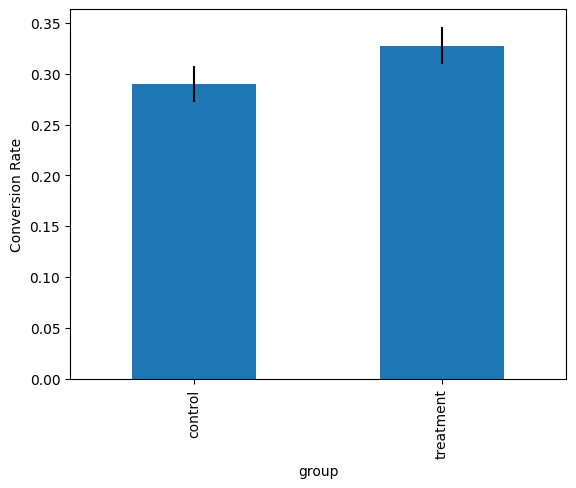

In [3]:
# --- Intro ---
# A/B Test Case Study (Synthetic Fintech Data)
# This notebook analyzes conversion, ARPU, and retention.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# --- Load Data ---
df = pd.read_csv("ab_test_data.csv")
df.head()

# --- SQL Summary ---
duckdb.query("""
SELECT "group",
       COUNT(DISTINCT user_id) AS users,
       AVG(conversion) AS conversion_rate,
       AVG(revenue) AS arpu,
       AVG(retained_30d) AS retention_rate
FROM df
GROUP BY "group";
""").to_df()

# --- Stats: Conversion ---
counts = df.groupby('group')['conversion'].sum().values
nobs = df.groupby('group')['user_id'].count().values
stat, pval = proportions_ztest(counts, nobs)
print("Conversion test:", stat, pval)

# --- Stats: ARPU (bootstrap) ---
def bootstrap_diff_means(a, b, n_boot=5000):
    obs = a.mean() - b.mean()
    pool = np.concatenate([a, b])
    diffs = []
    for _ in range(n_boot):
        a_s = np.random.choice(pool, len(a), replace=True)
        b_s = np.random.choice(pool, len(b), replace=True)
        diffs.append(a_s.mean() - b_s.mean())
    diffs = np.array(diffs)
    p = (np.sum(np.abs(diffs) >= np.abs(obs)) + 1) / (n_boot + 1)
    return obs, p

arpu_control = df.loc[df.group=='control', 'revenue']
arpu_treat   = df.loc[df.group=='treatment', 'revenue']
diff, pval = bootstrap_diff_means(arpu_treat, arpu_control)
print("ARPU diff:", diff, "p=", pval)

# --- Stats: Retention ---
counts_ret = df.groupby('group')['retained_30d'].sum().values
nobs_ret = df.groupby('group')['user_id'].count().values
stat, pval = proportions_ztest(counts_ret, nobs_ret)
print("Retention test:", stat, pval)

# --- Power Analysis (conversion) ---
p1 = 0.28; p2 = 0.32
effect = proportion_effectsize(p2, p1)
analysis = NormalIndPower()
n_per_group = analysis.solve_power(effect_size=effect, power=0.8, alpha=0.05)
print("Sample size needed per group:", n_per_group)

# --- Plot: Conversion Rate ---
grouped = df.groupby('group').agg(users=('user_id','count'),
                                  convs=('conversion','sum'))
grouped['rate'] = grouped['convs']/grouped['users']
grouped['se'] = np.sqrt(grouped['rate']*(1-grouped['rate'])/grouped['users'])
grouped['rate'].plot(kind='bar', yerr=1.96*grouped['se'], legend=False)
plt.ylabel("Conversion Rate")
plt.show()